In [1]:
import conllu_df
import lexicons
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
sns.set_theme(style="whitegrid", palette="colorblind")

# import warnings
# warnings.filterwarnings("ignore")


# Setup

In [2]:
langs = ['DE', 'EL', 'EU', 'FR', 'FR_sequoia', 'GA', 'HE', 'HI', 'IT', 'PL', 'PT', 'RO', 'SV', 'TR', 'TR2', 'ZH'] # []
datasets = ['test']
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
systems = ['ERMI.closed', 'FipsCo.open', 'HMSid.open', 'MTLB-STRUCT.open', 'Seen2Seen.closed', 'Seen2Unseen.open', 'TRAVIS-mono.open', 'TRAVIS-multi.open']

In [3]:
# read gold corpora and extract their MWEs
# takes about 3min to run


golds = {}
for lang in langs:
	golds[lang] = {}
	for dataset in datasets: #'train', 'dev', 'test', 'traindev',
		golds[lang][dataset] = {}
		print(lang, end=' ')
		if lang=='FR_sequoia':
			golds[lang]['traindevtest'] = {}
			filters = [
				[conllu_df.remove_NE],
				[conllu_df.remove_NE, conllu_df.remove_VMWE],
				[conllu_df.remove_NE, conllu_df.remove_nVMWE]]
			filter_names = ['MWE', 'non-VMWE', 'VMWE']
			for filter_name, filter in zip(filter_names, filters):
				tmp = conllu_df.setup_data_noTT(
					'untracked/1.2/'+lang+'/traindevtest.cupt',
					filter,
					None
				)
				golds[lang]['traindevtest'][filter_name] = {
					'df' : tmp,
					# 'sid' : conllu_df.sort_column(tmp),
					'mwes' : conllu_df.get_mwes(tmp)
				}
		else: 
			filters = [None]
			filter_names = ['none']
		for filter_name, filter in zip(filter_names, filters):
			tmp = conllu_df.setup_data_noTT(
				'untracked/1.2/'+lang+'/'+dataset+'.cupt',
				filter,
				None
			)
			golds[lang][dataset][filter_name] = {
				'df' : tmp,
				# 'sid' : conllu_df.sort_column(tmp),
				'mwes' : conllu_df.get_mwes(tmp)
			}


DE EL EU FR FR_sequoia GA HE HI IT PL PT RO SV TR TR2 ZH 

In [4]:
# extract MWEs from each systems predictions
# takes about 10~15min to run (on toasty laptop)
systems_pred = {}
for lang in langs:
	print(lang, end=' ')
	systems_pred[lang] = {}
	if lang == 'FR_sequoia':
		continue
	for system in systems:
		try :
			tmp = conllu_df.setup_data_noTT(
				'untracked/1.2/system-results/'+system+'/'+lang+'/test.system.cupt',
				# postproc_f=None
			)
			systems_pred[lang][system] = {
				# 'df' : tmp,
				# 'sid' : conllu_df.sort_column(tmp),
				'mwes' : conllu_df.get_mwes(tmp)
			}
		except FileNotFoundError:
			pass



DE EL EU FR FR_sequoia GA HE HI IT PL PT RO SV TR TR2 ZH 

In [5]:
# computes diversity score for gold and does it on samples of sequoia
# runs in about 15min

res_gold = pd.DataFrame({
	'lang': [],
	'corpus':[],
	'filter': [],
	'size': [],
	'richness': [],
	'normalize_r': [],
	'e10': [],
	'e21': [],
	'1/S': []})
for lang in langs:
	for corpus in datasets:
		if lang=='FR_sequoia':
			filter_names = ['MWE', 'non-VMWE', 'VMWE']
		else: 
			filter_names = ['none']
		for filter in filter_names:
			if lang=='FR_sequoia':
				for size in sizes:

					ss = ShuffleSplit(
						n_splits=12,
						train_size=size,
						random_state=152
					)
					for sample, _ in ss.split(golds[lang]['traindevtest'][filter]['df'].index.levels[0]):
					# a, _ = next(x)
						# sample= variables[lang][corpus][filter]['TTs'].index[sample]
						res_gold.loc[len(res_gold.index)] = {'lang': lang, 'corpus': 'traindevtest', 'filter': filter, 'size': size} | \
							lexicons.diversity_eval(
								conllu_df.inline_mwes(
									conllu_df.get_mwes(
										golds[lang]['traindevtest'][filter]['df'].loc[sample]
									)
								)
							)
				
				res_gold.loc[len(res_gold.index)] = {'lang': lang, 'corpus': 'traindevtest', 'filter': filter, 'size': 1} | \
					lexicons.diversity_eval(
						conllu_df.inline_mwes(
							conllu_df.get_mwes(
								golds[lang]['traindevtest'][filter]['df']
							)
						)
					)
			res_gold.loc[len(res_gold.index)] = {'lang': lang, 'corpus': corpus, 'filter': filter, 'size': 1} | \
					lexicons.diversity_eval(
						conllu_df.inline_mwes(
							conllu_df.get_mwes(
								golds[lang][corpus][filter]['df']
							)
						)
					)
res_gold['size'] = (res_gold['size'] * 100).apply(int)					

In [7]:
# computes diversity score for each system prediction

res_systems = pd.DataFrame({
	'lang': [],
	'system':[],
	'p': [],
	'r': [],
	'f': [],
	'richness': [],
	'normalize_r': [],
	'e10': [],
	'e21': [],
	'1/S': []})
for lang in langs:
	for system in systems:
		if system not in systems_pred[lang]:
			continue
		res_systems.loc[len(res_systems.index)] = {'lang': lang, 'system': system} | \
			lexicons.evaluate(
				golds[lang]['test']['none']['mwes'],
				systems_pred[lang][system]['mwes']
			)


In [8]:
with pd.option_context('display.float_format', '{:0.0f}'.format):
	pd.pivot(
		res_gold.loc[res_gold['filter'] == 'none'].melt(
			id_vars=['lang'],
			value_vars='richness'
		),
		values='value',
		columns=['lang'],
		index=['variable']
	)
	pd.pivot_table(
		res_systems[['lang', 'system', 'richness']],
		values= 'richness',
		index=['system'],
		columns=['lang'],
		fill_value=''
	)
with pd.option_context('display.float_format', '{:0.2f}'.format):
	(pd.pivot(
		res_gold.loc[res_gold['filter'] == 'none'].melt(
			id_vars=['lang'],
			value_vars='e21'
		),
		values='value',
		columns=['lang'],
		index=['variable']
	) * 100)
	(pd.pivot_table(
			res_systems[['lang', 'system', 'e10', 'e21']],
			values= 'e21',
			index=['system'],
			columns=['lang'],
			fill_value=''
		) * 100)

lang,DE,EL,EU,FR,GA,HE,HI,IT,PL,PT,RO,SV,TR,TR2,ZH
variable,,,,,,,,,,,,,,,
richness,585,682,561,712,310,443,335,638,689,815,465,495,719,660,551


lang,DE,EL,EU,FR,GA,HE,HI,IT,PL,PT,RO,SV,TR,TR2,ZH
system,,,,,,,,,,,,,,,
ERMI.closed,230,352,327,392,37,95,183,165,355,453,312,241,390,,272
FipsCo.open,212,191,,392,,,,,,,,,,,
HMSid.open,,,,454,,,,,,,,,,,
MTLB-STRUCT.open,400,472,387,505,73,171,234,330,465,549,365,345,455,,365
Seen2Seen.closed,274,358,280,406,22,116,67,315,384,489,250,208,389,401,249
Seen2Unseen.open,290,381,333,466,48,123,170,336,416,521,259,223,435,,253
TRAVIS-mono.open,381,55,,531,,,7,341,487,,369,307,472,,398
TRAVIS-multi.open,348,452,368,471,14,144,176,310,449,,300,286,488,,355


lang,DE,EL,EU,FR,GA,HE,HI,IT,PL,PT,RO,SV,TR,TR2,ZH
variable,,,,,,,,,,,,,,,
e21,43.40,63.95,30.30,40.42,63.88,91.08,42.48,57.05,51.38,71.67,30.90,69.28,58.59,58.14,38.12


lang,DE,EL,EU,FR,GA,HE,HI,IT,PL,PT,RO,SV,TR,TR2,ZH
system,,,,,,,,,,,,,,,
ERMI.closed,42.53,59.32,34.61,42.42,65.76,90.75,50.55,52.49,54.18,69.61,34.20,69.43,57.58,,43.85
FipsCo.open,85.67,55.44,,47.98,,,,,,,,,,,
HMSid.open,,,,45.46,,,,,,,,,,,
MTLB-STRUCT.open,43.00,62.34,33.57,41.97,56.13,89.33,41.32,56.06,53.87,71.79,33.16,69.63,58.41,,42.62
Seen2Seen.closed,41.72,62.22,39.05,44.73,70.14,88.30,50.31,58.34,56.73,72.25,35.54,74.38,60.06,60.08,45.66
Seen2Unseen.open,41.68,62.14,36.94,43.52,60.90,88.20,40.89,58.03,55.84,72.02,35.24,73.81,59.61,,45.59
TRAVIS-mono.open,42.09,75.34,,41.76,,,89.33,56.18,54.15,,33.20,69.15,56.97,,42.25
TRAVIS-multi.open,41.52,62.46,34.28,41.91,80.37,90.34,64.68,55.34,54.09,,35.46,72.94,57.93,,45.04


,p,r,f,richness,normalize_r,e10,e21,1/S
p,1.000000,0.709571,0.819348,0.492538,-0.583756,-0.538604,-0.467483,-0.287875
r,0.709571,1.000000,0.975310,0.830623,-0.461302,-0.577739,-0.618588,-0.276765
f,0.819348,0.975310,1.000000,0.777576,-0.486209,-0.582227,-0.607016,-0.260852
richness,0.492538,0.830623,0.777576,1.000000,-0.082476,-0.221708,-0.374272,-0.058402
normalize_r,-0.583756,-0.461302,-0.486209,-0.082476,1.000000,0.886531,0.557526,0.647580
e10,-0.538604,-0.577739,-0.582227,-0.221708,0.886531,1.000000,0.834672,0.764774
e21,-0.467483,-0.618588,-0.607016,-0.374272,0.557526,0.834672,1.000000,0.821667
1/S,-0.287875,-0.276765,-0.260852,-0.058402,0.647580,0.764774,0.821667,1.000000


correlation after aggregation per lang, per system


,p,r,f,richness,normalize_r,e10,e21,1/S
p,1.000000,0.863428,0.928783,0.575914,-0.666828,-0.624419,-0.558284,-0.312593
r,0.863428,1.000000,0.986056,0.820371,-0.576389,-0.611646,-0.603342,-0.297347
f,0.928783,0.986056,1.000000,0.779464,-0.594399,-0.610988,-0.586271,-0.274048
richness,0.575914,0.820371,0.779464,1.000000,-0.135165,-0.202829,-0.316070,-0.041170
normalize_r,-0.666828,-0.576389,-0.594399,-0.135165,1.000000,0.921749,0.659985,0.677561
e10,-0.624419,-0.611646,-0.610988,-0.202829,0.921749,1.000000,0.865608,0.779168
e21,-0.558284,-0.603342,-0.586271,-0.316070,0.659985,0.865608,1.000000,0.854681
1/S,-0.312593,-0.297347,-0.274048,-0.041170,0.677561,0.779168,0.854681,1.000000


,p,r,f,richness,normalize_r,e10,e21,1/S
p,1.000000,0.625679,0.779130,0.114720,-0.752704,-0.578126,-0.236921,-0.571304
r,0.625679,1.000000,0.968079,0.718255,-0.650903,-0.811253,-0.748102,-0.761429
f,0.779130,0.968079,1.000000,0.576375,-0.738576,-0.830326,-0.664550,-0.751419
richness,0.114720,0.718255,0.576375,1.000000,-0.160456,-0.551713,-0.874150,-0.599825
normalize_r,-0.752704,-0.650903,-0.738576,-0.160456,1.000000,0.852517,0.473476,0.786067
e10,-0.578126,-0.811253,-0.830326,-0.551713,0.852517,1.000000,0.841510,0.924179
e21,-0.236921,-0.748102,-0.664550,-0.874150,0.473476,0.841510,1.000000,0.829712
1/S,-0.571304,-0.761429,-0.751419,-0.599825,0.786067,0.924179,0.829712,1.000000


<AxesSubplot:xlabel='f', ylabel='richness'>

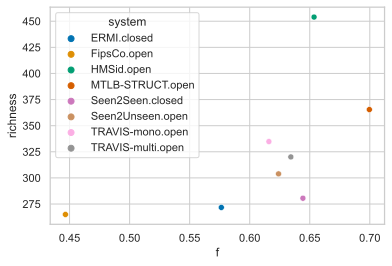

In [9]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
	res_systems.corr().style.background_gradient(cmap='vlag')
	print('correlation after aggregation per lang, per system')
	res_systems.groupby('lang').mean().corr().style.background_gradient(cmap='vlag')
	res_systems.groupby('system').mean().corr().style.background_gradient(cmap='vlag')
	sns.scatterplot(
		res_systems.groupby('system').mean(),
		x='f',
		y='richness',
		hue='system'
	)

In [10]:
# whatif we measure we consider system e21 better when close to gold e21

tmp =pd.merge(
	res_systems,
	res_gold[['lang', 'e21']],
	left_on='lang',
	right_on='lang'
)
tmp['diff'] = (tmp['e21_x'] - tmp['e21_y']).abs()
tmp.corr().style.background_gradient(cmap='vlag')


,p,r,f,richness,normalize_r,e10,e21_x,1/S,e21_y,diff
p,1.000000,0.709571,0.819348,0.492538,-0.583756,-0.538604,-0.467483,-0.287875,-0.393431,-0.235298
r,0.709571,1.000000,0.975310,0.830623,-0.461302,-0.577739,-0.618588,-0.276765,-0.464490,-0.458380
f,0.819348,0.975310,1.000000,0.777576,-0.486209,-0.582227,-0.607016,-0.260852,-0.436838,-0.472438
richness,0.492538,0.830623,0.777576,1.000000,-0.082476,-0.221708,-0.374272,-0.058402,-0.226148,-0.416117
normalize_r,-0.583756,-0.461302,-0.486209,-0.082476,1.000000,0.886531,0.557526,0.647580,0.598009,0.024179
e10,-0.538604,-0.577739,-0.582227,-0.221708,0.886531,1.000000,0.834672,0.764774,0.791846,0.161775
e21_x,-0.467483,-0.618588,-0.607016,-0.374272,0.557526,0.834672,1.000000,0.821667,0.873752,0.269099
1/S,-0.287875,-0.276765,-0.260852,-0.058402,0.647580,0.764774,0.821667,1.000000,0.822147,-0.009213
e21_y,-0.393431,-0.464490,-0.436838,-0.226148,0.598009,0.791846,0.873752,0.822147,1.000000,-0.196375
diff,-0.235298,-0.458380,-0.472438,-0.416117,0.024179,0.161775,0.269099,-0.009213,-0.196375,1.000000


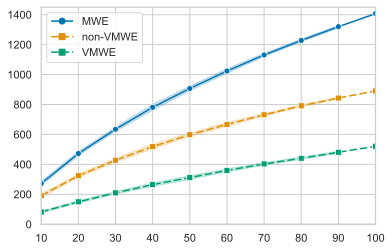

In [11]:
_ = sns.lineplot(
	data= res_gold.loc[lambda x: x['filter'] != 'none'].loc[lambda x: x['corpus'] !='test'],
	x='size',
	y='richness',
	hue='filter',
	style='filter',
	markers=['o', 's', 's'],
	dashes=[(1, 0), (5,2), (5,2)],
	errorbar='sd'
)
_ = plt.xlim([10, 100])
_ = plt.ylim([0, 1450])
_ = plt.xlabel('')
_ = plt.ylabel('')
_ = plt.legend()

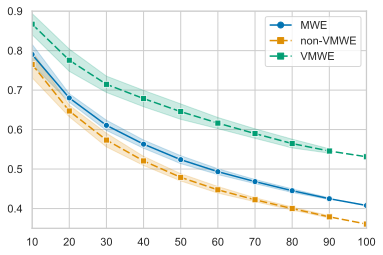

In [12]:
_ = sns.lineplot(
	data= res_gold.loc[lambda x: x['filter'] != 'none'].loc[lambda x: x['corpus'] !='test'],
	x='size',
	y='normalize_r',
	hue='filter',
	style='filter',
	markers=['o', 's', 's'],
	dashes=[(1, 0), (5,2), (5,2)],
	errorbar='sd'
)
_ = plt.xlim([10, 100])
_ = plt.ylim([0.35, 0.9])
_ = plt.xlabel('')
_ = plt.ylabel('')
_ = plt.legend()

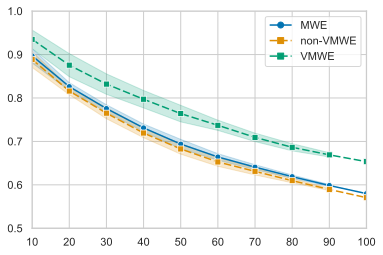

In [13]:
_ = sns.lineplot(
	data= res_gold.loc[lambda x: x['filter'] != 'none'].loc[lambda x: x['corpus'] !='test'],
	x='size',
	y='e10',
	hue='filter',
	style='filter',
	markers=['o', 's', 's'],
	dashes=[(1, 0), (5,2), (5,2)],
	errorbar='sd'
)
_ = plt.xlim([10, 100])
_ = plt.ylim([0.5, 1])
_ = plt.xlabel('')
_ = plt.ylabel('')
_ = plt.legend()

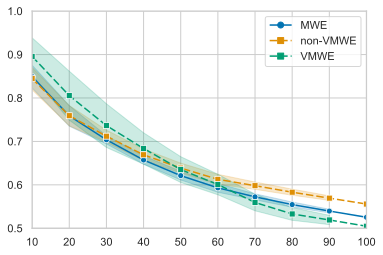

In [14]:
_ = sns.lineplot(
	data= res_gold.loc[lambda x: x['filter'] != 'none'].loc[lambda x: x['corpus'] !='test'],
	x='size',
	y='e21',
	hue='filter',
	style='filter',
	markers=['o', 's', 's'],
	dashes=[(1, 0), (5,2), (5,2)],
	errorbar='sd'
)
_ = plt.xlim([10, 100])
_ = plt.ylim([0.5, 1])
_ = plt.xlabel('')
_ = plt.ylabel('')
_ = plt.legend()

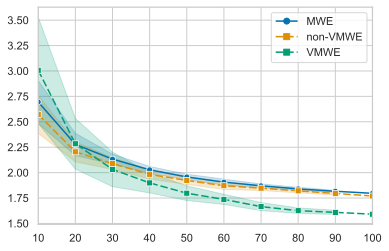

In [15]:
_ = sns.lineplot(
	data= res_gold.loc[lambda x: x['filter'] != 'none'].loc[lambda x: x['corpus'] !='test'],
	x='size',
	y='1/S',
	hue='filter',
	style='filter',
	# errorbar='sd',
	markers=['o', 's', 's'],
	dashes=[(1, 0), (5,2), (5,2)],
	errorbar='sd'
)
_ = plt.xlim([10, 100])
_ = plt.xlabel('')
_ = plt.ylabel('')
_ = plt.legend()

In [16]:
z = pd.DataFrame({
	'n': [],
	'size': [],
	'filter': [],
	'rank': []
})
for filter in ['MWE']:
	for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
		ss = ShuffleSplit(
			n_splits=12,
			train_size=size,
			random_state=152
		)
		
		for sample, _ in ss.split(golds['FR_sequoia']['traindevtest'][filter]['df'].index.levels[0]):

			true_pred = conllu_df.inline_mwes(
				conllu_df.get_mwes(
					golds['FR_sequoia']['traindevtest'][filter]['df'].loc[sample]
				)
			)
			tp_grpby = true_pred.assign(n=1).groupby(0).count()['n']
			n = sum(tp_grpby)

			tmp = pd.DataFrame(tp_grpby.sort_values(ascending=False)).assign(**{'size': size, 'filter': filter}).reset_index(drop=True)
			tmp['rank'] = range(1, len(tmp)+1)
			z = pd.concat([z, tmp])


	true_pred = conllu_df.inline_mwes(
		conllu_df.get_mwes(
			golds['FR_sequoia']['traindevtest'][filter]['df']
		)
	)
	tp_grpby = true_pred.assign(n=1).groupby(0).count()['n']
	n = sum(tp_grpby)
	# tp_grpby = tp_grpby / sum(tp_grpby)
	tmp = pd.DataFrame(tp_grpby.sort_values(ascending=False)).assign(**{'size': 1, 'filter': filter}).reset_index(drop=True)
	tmp['rank'] = range(1, len(tmp)+1)
	z = pd.concat([z, tmp])	
z['size'] = (z['size'] * 100).apply(int)

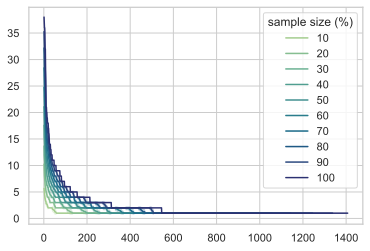

In [17]:
_ = sns.lineplot(
	data=z.loc[lambda x: x['filter'] == 'MWE'],
	x='rank',
	y='n',
	hue='size',
	errorbar='sd',
	legend='full',
	palette='crest'
)
_ = plt.legend(title='sample size (%)')
_ = plt.xlabel('')
_ = plt.ylabel('')
# plt.legend()

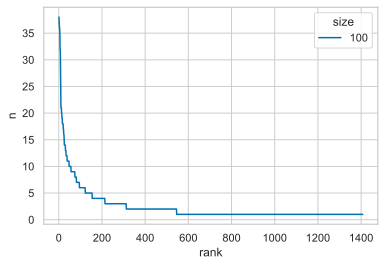

In [23]:
_ = sns.lineplot(
	data=z.loc[lambda x: x['size'] == 100],
	x='rank',
	y='n',
	hue='size',
	palette=sns.color_palette("colorblind")[0:1]
)